# Spike Sorting of Crayfish Ganglia

## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the *mne-python* package. This will come in handy for preprocessing and analysis.

In [1]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17918002.abf'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load recordings.
recordings, = neo.AxonIO(filename=f).read_block().segments
nerve, = recordings.analogsignals

## Concatenate raw recordings.
data = np.hstack([np.asarray(nerve, dtype=np.float64)  * 1e-6, # uV --> V 
                 ]).T

## Create info object.
sfreq = float(nerve.sampling_rate)
ch_names = ['nerve']
ch_types = 'bio'

info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

## Create Raw object.
raw = RawArray(data, info)

## Save Raw object.
raw.save('raw/spike_sorting_raw.fif', overwrite=True, verbose=False)
print('Done.')

Creating RawArray with float64 data, n_channels=1, n_times=552448
    Range : 0 ... 552447 =      0.000 ...    55.245 secs
Ready.
Done.


## Step 2: Preprocess Recording
Next, we open the raw FIFF file and preform preprocessing. For this dataset, preprocessing will entail only filtering the data to remove slow-frequency drifts and high-frequency noise. [Gonzalo Rey et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0361923015000684) recommend a high- and low-pass of 300 and 3000 Hz, respectively, for the extracellular nerve recording.

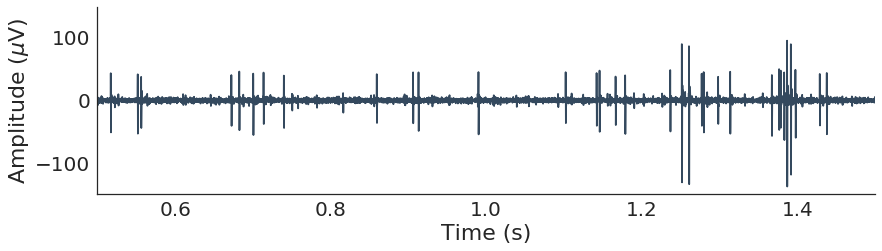

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/spike_sorting_raw.fif'

## Filter parameters (nerve).
filter_dict = dict( nerve = (300, 3000) )

## Plotting parameters.
tmin = 0.5
tmax = 1.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load raw.
raw = Raw(f, preload=True, verbose=False)

## Filter data.
for ch_name in raw.ch_names:
    picks = pick_channels(raw.ch_names, include=[ch_name])
    raw = raw.filter(*filter_dict[ch_name], picks=picks, method='fir', phase='zero')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Extract data.
arr, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Plot plot.
ax.plot(times, arr.squeeze() * 1e6, color="#34495e")
y = np.abs(ax.get_ylim()).max()
ax.set(xlim=(tmin, tmax), xlabel='Time (s)', ylim=(-y, y), ylabel=r'Amplitude ($\mu$V)')
    
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0.05)

## Step 3: Peak Finding
From the plot above, it should be fairly obvious that the action potentials of the nerve align with the excitatory post-synaptic potentials (EPSPs) of the muscle fibers. To confirm this, we need to perform peak-detection. There are many viable peak-detection algorithms. We stick with a simple homebrew implementation of amplitude-thresholding. In this approach, contiguous sections of data above some positive threshold are identified; the maximum point for each cluster is returned as a peak. 

We define our threshold following [Quian-Quiroga et al. (2004)](http://www.mitpressjournals.org/doi/abs/10.1162/089976604774201631). The formula is straightforward: 

> $T = k \cdot \frac{median(|X|)}{0.6745} $

where the numberator is the median of the absolute value of the recording, $X$; the denominator is inverse of the cumulative distribution function for the standard normal distribution (see Quian-Quiroga et al., 2004); and $k$ is some constant (e.g. $k$=5). Below we motivate the choice of the constant, $k$, visualizing what percentage of the total data is beneath some threshold, $T$.

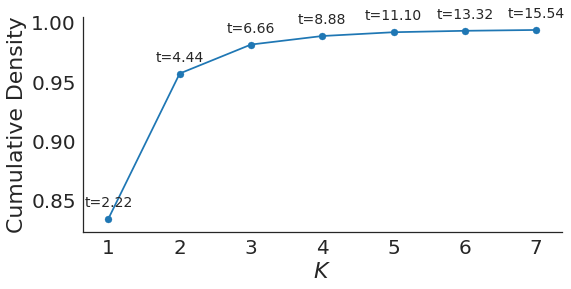

In [3]:
from peak_detection import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute thresholds.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract nerve data.
arr = raw.get_data(picks=pick_channels(raw.ch_names, ['nerve'])).squeeze()

## Compute cumulative density of data beneath threshold.
K = np.arange(1,8)
T = [find_threshold(arr, k) for k in K]
cdf = [(t > arr).mean() for t in T]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(K,cdf)
ax.scatter(K,cdf)
for k, y, t in zip(K, cdf, T): ax.text(k, y+1e-2, 't=%0.2f' %(t*1e6), ha='center', fontsize=14)
ax.set(xlabel=r'$K$', ylabel=r'Cumulative Density')
    
sns.despine()
plt.tight_layout()

As can be seen, $T=5$ is a fairly conservative threshold, greater than over 99% of the total data points in the raw recording. Below, we identify peaks using this threshold and additionally perform peak censoring [(Hill et al., 2011)](http://www.jneurosci.org/content/31/24/8699.short).

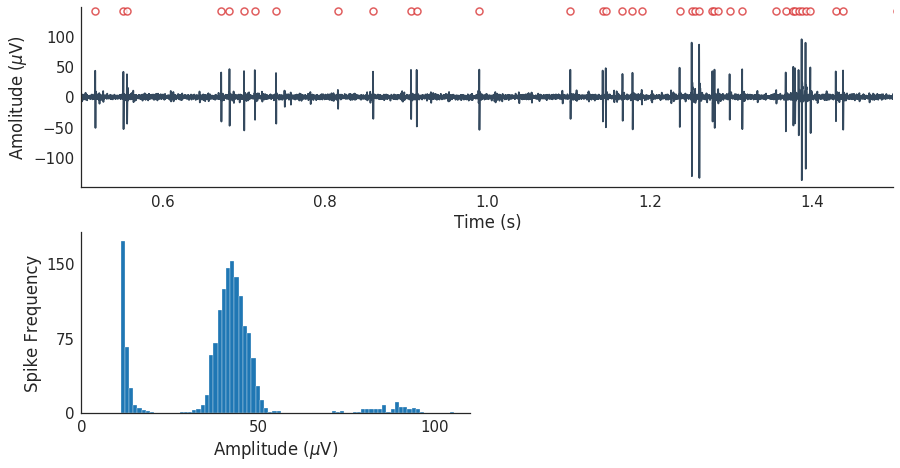

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform peak detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract nerve data.
arr = raw.get_data(picks=pick_channels(raw.ch_names, ['nerve'])).squeeze()

## Threshold.
k = 5
threshold = find_threshold(arr, k)

## Find peaks,
peak_loc, peak_mag = peak_finder(arr, threshold)

## Censor peaks.
peak_loc, peak_mag = peak_censor(raw.times, peak_loc, peak_mag, min_dist=2e-3)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))
sns.set_context('notebook', font_scale=1.5)

## Extract data.
arr, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Plot spikes.
ax = plt.subplot2grid((2,4),(0,0),colspan=4)
ax.plot(times, arr.squeeze() * 1e6, color="#34495e")
y = np.abs(ax.get_ylim()).max()
ax.scatter(raw.times[peak_loc], np.ones_like(peak_loc)*y*0.95, marker='o', 
           color='w', edgecolor='#d62728', linewidth=1.5, alpha=0.75)
ax.set(xlim=(tmin, tmax), xlabel='Time (s)', ylim=(-y, y), ylabel=r'Amolitude ($\mu$V)')

## Plot histogram of spike magnitudes.
ax = plt.subplot2grid((2,4),(1,0),colspan=2)
ax.hist(peak_mag * 1e6, bins=100, edgecolor='w')
ax.set(xlim=(0,110), xticks=(0,50,100), xlabel=r'Amplitude ($\mu$V)', yticks=(0,75, 150), ylabel='Spike Frequency')

sns.despine()
plt.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.05, hspace=0.25)

## Step 4: Spike Sorting

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


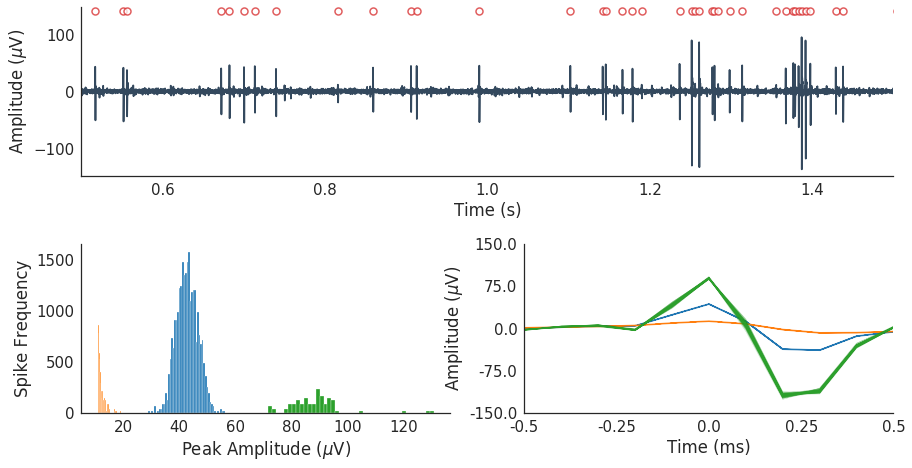

In [5]:
from mne import Epochs
from pandas import DataFrame
from sklearn.cluster import KMeans
def zscore(arr): return (arr - arr.mean()) / arr.std()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Make epochs.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define events. 
events = np.vstack([peak_loc, np.zeros_like(peak_loc), np.ones_like(peak_loc)]).T
picks=pick_channels(raw.ch_names, ['nerve'])

## Make epochs.
epochs = Epochs(raw, events, tmin=-1e-3, tmax=1e-3, baseline=None, picks=picks, verbose=False)

## Re-extract info.
data = epochs.get_data().squeeze()
peak_mag = data.max(axis=1)
peak_times = raw.times[epochs.events[:,0]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Clustering.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare magnitudes.
zmag = zscore(peak_mag).reshape(-1,1)

## K-means clustering on peak magnitudes.
kmeans = KMeans(n_clusters=3)
categories = kmeans.fit_predict(zmag)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble information into DataFrame.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize DataFrame.
df = DataFrame(data)

## Add metadata.
df['Epoch'] = np.arange(data.shape[0]) + 1
df['Peak Amplitude'] = peak_mag
df['Peak Time'] = peak_times
df['Category'] = categories

## Melt.
df = df.melt(id_vars=('Epoch', 'Peak Amplitude', 'Peak Time', 'Category'), var_name='Sample', value_name='Voltage')
df.Sample = epochs.times[df.Sample.as_matrix().astype(int)]
df.to_csv('spike_sorting.csv', index=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))
sns.set_context('notebook', font_scale=1.5)

## Extract data.
arr, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Plot spikes.
ax = plt.subplot2grid((2,2),(0,0),colspan=2)
ax.plot(times, arr.squeeze() * 1e6, color="#34495e")
y = np.abs(ax.get_ylim()).max()
ax.scatter(raw.times[peak_loc], np.ones_like(peak_loc)*y*0.95, marker='o', 
           color='w', edgecolor='#d62728', linewidth=1.5, alpha=0.75)
ax.set(xlim=(tmin, tmax), xlabel='Time (s)', ylim=(-y, y), ylabel=r'Amplitude ($\mu$V)')

## Plot histogram of spike magnitudes.
ax = plt.subplot2grid((2,2),(1,0))
for i in df.Category.unique():
    arr = df.loc[df.Category==i,'Peak Amplitude'] * 1e6
    sns.distplot(arr, kde=False, hist_kws=dict(alpha=1, edgecolor='w'), ax=ax)
ax.set(xlabel=r'Peak Amplitude ($\mu$V)', ylabel='Spike Frequency')

## Plot timecourses of spikes.
ax = plt.subplot2grid((2,2),(1,1))
xticks = np.linspace(-0.5e-3,0.5e-3,5)
yticks = np.linspace(-150e-6,150e-6,5)

sns.tsplot(df, time='Sample', unit='Epoch', condition='Category', value='Voltage', legend=False, 
           err_style='boot_traces', n_boot=250, alpha=0.7, ax=ax)
ax.set(xlim=(xticks.min(), xticks.max()), xticks=xticks, xticklabels=xticks*1e3, xlabel='Time (ms)',
       yticks=yticks, yticklabels=yticks*1e6, ylabel='Amplitude ($\mu$V)')

sns.despine()
plt.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.05, hspace=0.4)

## References
1. Hill, D. N., Mehta, S. B., & Kleinfeld, D. (2011). Quality metrics to accompany spike sorting of extracellular signals. Journal of Neuroscience, 31(24), 8699-8705.
2. Quiroga, R. Q., Nadasdy, Z., & Ben-Shaul, Y. (2004). Unsupervised spike detection and sorting with wavelets and superparamagnetic clustering. Neural computation, 16(8), 1661-1687.
3. Rey, H. G., Pedreira, C., & Quiroga, R. Q. (2015). Past, present and future of spike sorting techniques. Brain research bulletin, 119, 106-117. Chicago.
